# Carbon Intensity UK - Анализ данных из Data Marts

Этот ноутбук загружает данные из витрины DBT и строит визуализации для анализа углеродной интенсивности электроэнергии в UK.

## Первый запуск

Если вы запускаете в первый раз, выполните следующую ячейку для установки библиотек:

In [14]:
# Установка необходимых библиотек (выполните один раз)
!pip install -q pandas matplotlib seaborn sqlalchemy psycopg2-binary

print("Библиотеки установлены!")

Библиотеки установлены!


# Carbon Intensity UK - Аналитический отчет

> **Анализ данных о carbon intensity электроэнергии UK энергосистемы**

**Цель:** Получение инсайтов из данных о carbon intensity для оптимизации энергопотребления

**Источник данных:** PostgreSQL Data Marts (dm_carbon_intensity_analytics, dm_carbon_intensity_daily_report)

## Содержание

1. [Подключение к базе данных](#1-подключение-к-базе-данных)
2. [Обзор данных](#2-обзор-данных)
3. [Анализ трендов carbon intensity](#3-анализ-трендов-carbon-intensity)
4. [Анализ по времени суток и дням недели](#4-анализ-по-времени-суток)
5. [Анализ точности прогнозов](#5-анализ-точности-прогнозов)
6. [Детекция аномалий](#6-детекция-аномалий)
7. [Рекомендации по энергопотреблению](#7-рекомендации-по-энергопотреблению)
8. [Выводы и инсайты](#8-выводы-и-инсайты)

## 1. Подключение к базе данных

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
from datetime import datetime, timedelta

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 11

print("Библиотеки импортированы")

Библиотеки импортированы


In [16]:
"""
Функция для подключения к PostgreSQL.

Returns:
    engine: SQLAlchemy engine для подключения к БД
"""
def get_database_connection():
    # Параметры подключения к PostgreSQL
    DB_HOST = 'postgres'
    DB_PORT = '5432'
    DB_USER = 'airflow'
    DB_PASSWORD = 'airflow'
    DB_NAME = 'analytics'
    
    connection_string = f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
    
    engine = create_engine(connection_string)
    
    return engine

engine = get_database_connection()
print("Подключение к базе данных установлено")

Подключение к базе данных установлено


## 2. Обзор данных

In [17]:
# Загрузка данных из аналитической витрины
query_analytics = """
SELECT 
    period_start,
    data_date,
    data_hour,
    time_of_day,
    day_type,
    data_day_of_week,
    forecast_co2_gco2_kwh,
    actual_co2_gco2_kwh,
    forecast_category,
    forecast_error,
    forecast_error_percent,
    is_forecast_accurate,
    energy_cleanliness_level,
    is_peak_carbon_period,
    consumption_recommendation,
    intensity_z_score,
    is_statistical_anomaly,
    intensity_anomaly_type
FROM public_marts.dm_carbon_intensity_analytics
WHERE data_date >= CURRENT_DATE - INTERVAL '30 days'
ORDER BY period_start DESC
LIMIT 5000
"""

df = pd.read_sql(query_analytics, engine)
df['period_start'] = pd.to_datetime(df['period_start'])
df['data_date'] = pd.to_datetime(df['data_date'])

print(f"Загружено записей: {len(df)}")
print(f"Период данных: {df['data_date'].min()} - {df['data_date'].max()}")
print(f"\nОбщая информация:")
df.info()

Загружено записей: 533
Период данных: 2025-12-05 00:00:00 - 2025-12-12 00:00:00

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   period_start                533 non-null    datetime64[ns]
 1   data_date                   533 non-null    datetime64[ns]
 2   data_hour                   533 non-null    float64       
 3   time_of_day                 533 non-null    object        
 4   day_type                    533 non-null    object        
 5   data_day_of_week            533 non-null    object        
 6   forecast_co2_gco2_kwh       533 non-null    int64         
 7   actual_co2_gco2_kwh         507 non-null    float64       
 8   forecast_category           533 non-null    object        
 9   forecast_error              507 non-null    float64       
 10  forecast_error_percent 

In [18]:
# Базовая статистика
print("Статистика по forecast_co2_gco2_kwh:")
print(df['forecast_co2_gco2_kwh'].describe())

print("\nРаспределение по категориям интенсивности:")
print(df['forecast_category'].value_counts())

print("\nРаспределение по уровню чистоты энергии:")
print(df['energy_cleanliness_level'].value_counts())

Статистика по forecast_co2_gco2_kwh:
count    533.000000
mean     100.245779
std       46.088318
min       35.000000
25%       68.000000
50%       88.000000
75%      123.000000
max      237.000000
Name: forecast_co2_gco2_kwh, dtype: float64

Распределение по категориям интенсивности:
forecast_category
very_low    320
low         133
moderate     57
high         23
Name: count, dtype: int64

Распределение по уровню чистоты энергии:
energy_cleanliness_level
green_energy       320
moderate_impact    192
standard            21
Name: count, dtype: int64


## 3. Анализ трендов carbon intensity

**Визуализация изменения carbon intensity во времени**

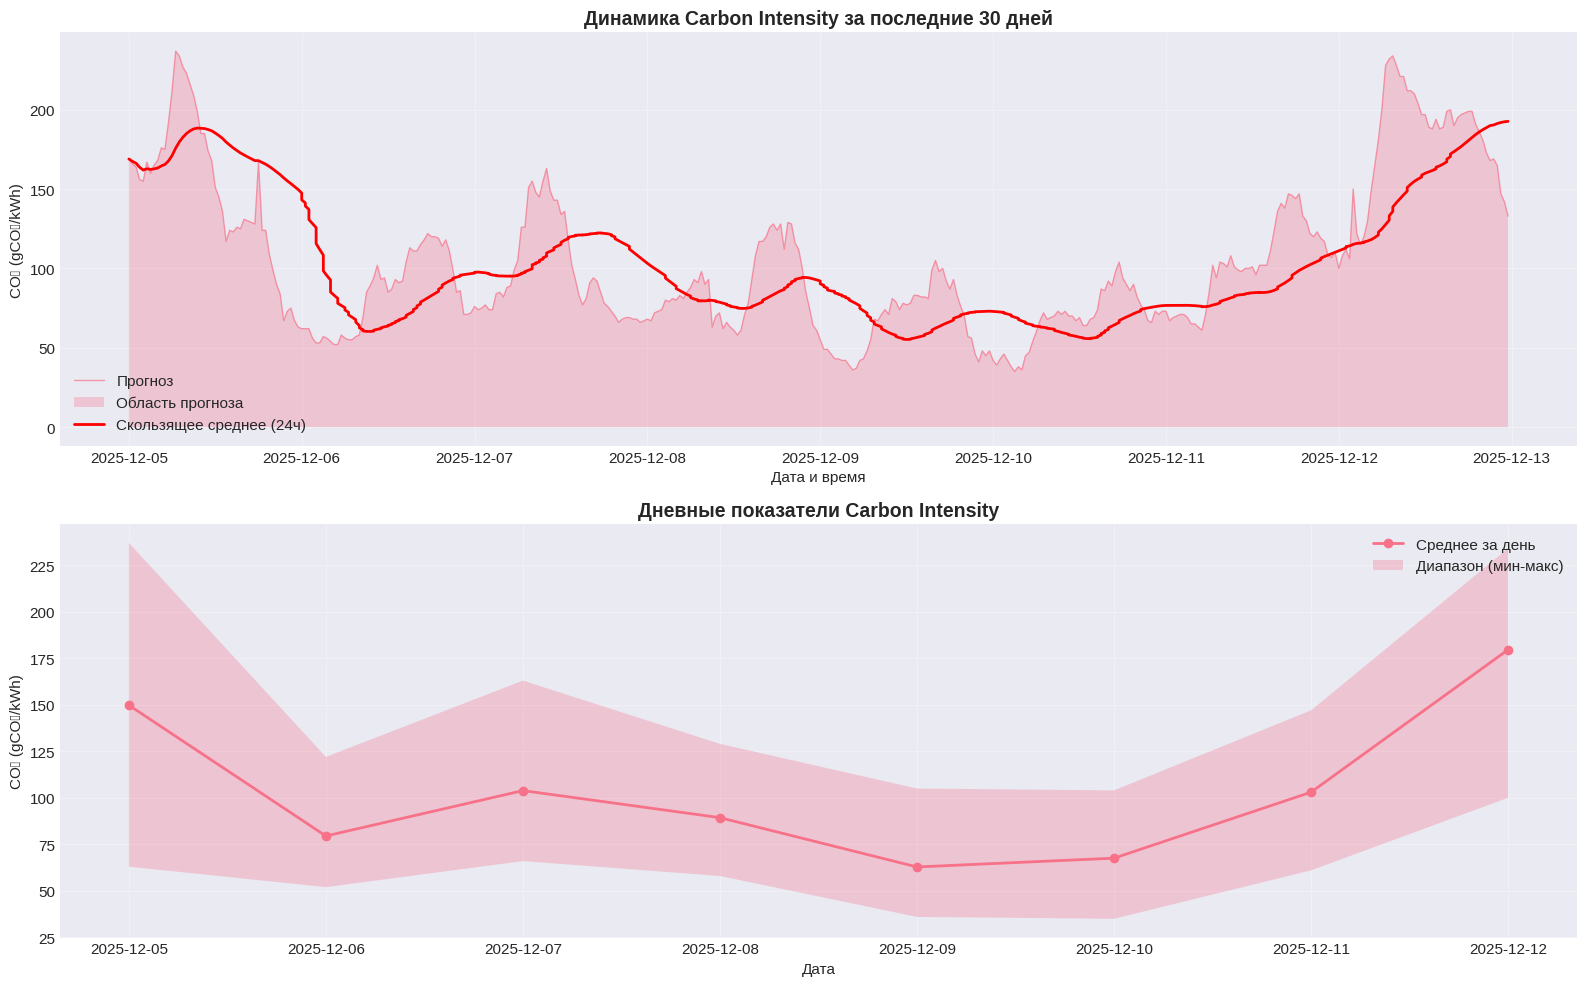

Средняя интенсивность: 100.25 gCO₂/kWh
Максимум: 237.00 gCO₂/kWh
Минимум: 35.00 gCO₂/kWh


In [19]:
# График трендов за последние 30 дней
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# График 1: Временной ряд интенсивности
axes[0].plot(df['period_start'], df['forecast_co2_gco2_kwh'], 
             label='Прогноз', alpha=0.7, linewidth=1)
axes[0].fill_between(df['period_start'], df['forecast_co2_gco2_kwh'], 
                      alpha=0.3, label='Область прогноза')

# Добавляем скользящее среднее
df_sorted = df.sort_values('period_start')
ma_24h = df_sorted['forecast_co2_gco2_kwh'].rolling(window=48, min_periods=1).mean()
axes[0].plot(df_sorted['period_start'], ma_24h, 
             label='Скользящее среднее (24ч)', color='red', linewidth=2)

axes[0].set_title('Динамика Carbon Intensity за последние 30 дней', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Дата и время')
axes[0].set_ylabel('CO₂ (gCO₂/kWh)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# График 2: Распределение по дням
daily_avg = df.groupby('data_date')['forecast_co2_gco2_kwh'].agg(['mean', 'min', 'max'])
axes[1].plot(daily_avg.index, daily_avg['mean'], label='Среднее за день', marker='o', linewidth=2)
axes[1].fill_between(daily_avg.index, daily_avg['min'], daily_avg['max'], 
                      alpha=0.3, label='Диапазон (мин-макс)')

axes[1].set_title('Дневные показатели Carbon Intensity', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Дата')
axes[1].set_ylabel('CO₂ (gCO₂/kWh)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Средняя интенсивность: {df['forecast_co2_gco2_kwh'].mean():.2f} gCO₂/kWh")
print(f"Максимум: {df['forecast_co2_gco2_kwh'].max():.2f} gCO₂/kWh")
print(f"Минимум: {df['forecast_co2_gco2_kwh'].min():.2f} gCO₂/kWh")

## 4. Анализ по времени суток

**Как меняется carbon intensity в зависимости от времени суток и дня недели**

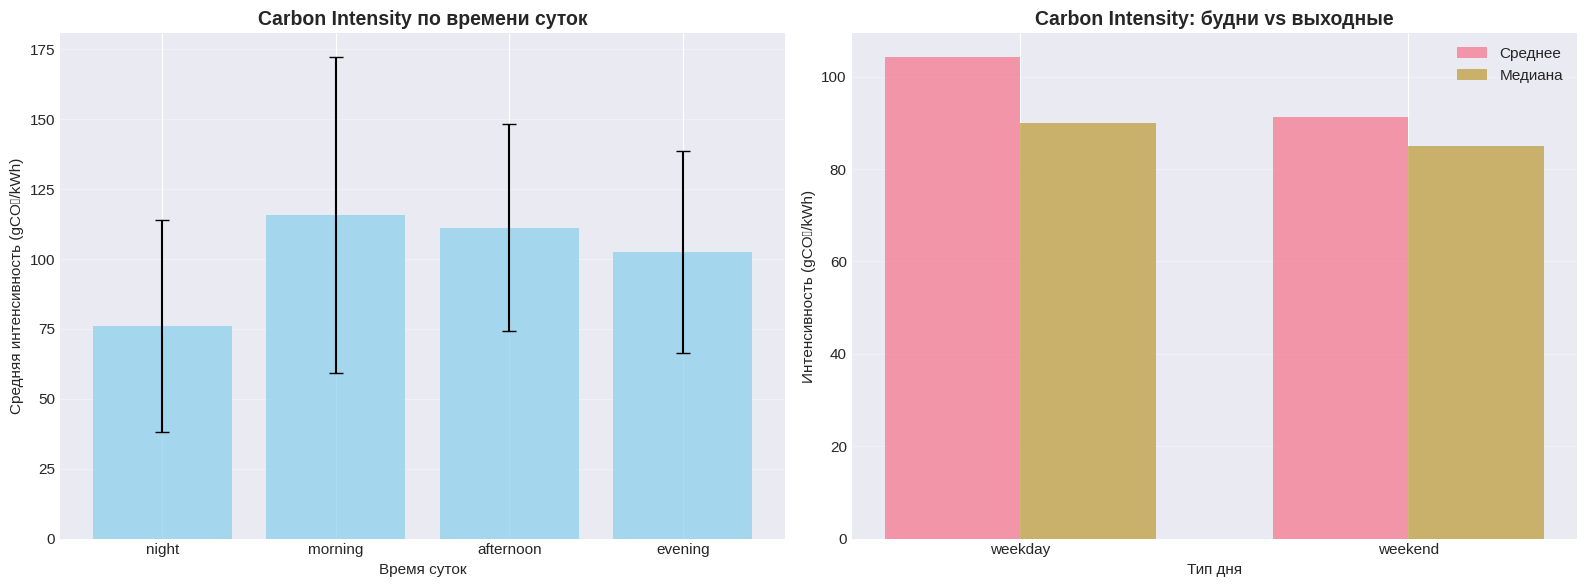


Инсайт:
Лучшее время для энергопотребления: night
Худшее время для энергопотребления: morning


In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График 1: По времени суток
time_of_day_stats = df.groupby('time_of_day')['forecast_co2_gco2_kwh'].agg(['mean', 'std'])
time_of_day_order = ['night', 'morning', 'afternoon', 'evening']
time_of_day_stats = time_of_day_stats.reindex(time_of_day_order)

axes[0].bar(time_of_day_stats.index, time_of_day_stats['mean'], 
            yerr=time_of_day_stats['std'], capsize=5, alpha=0.7, color='skyblue')
axes[0].set_title('Carbon Intensity по времени суток', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Время суток')
axes[0].set_ylabel('Средняя интенсивность (gCO₂/kWh)')
axes[0].grid(axis='y', alpha=0.3)

# График 2: По типу дня (будний/выходной)
day_type_stats = df.groupby('day_type')['forecast_co2_gco2_kwh'].agg(['mean', 'median'])

x = np.arange(len(day_type_stats))
width = 0.35
axes[1].bar(x - width/2, day_type_stats['mean'], width, label='Среднее', alpha=0.7)
axes[1].bar(x + width/2, day_type_stats['median'], width, label='Медиана', alpha=0.7)
axes[1].set_title('Carbon Intensity: будни vs выходные', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Тип дня')
axes[1].set_ylabel('Интенсивность (gCO₂/kWh)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(day_type_stats.index)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nИнсайт:")
best_time = time_of_day_stats['mean'].idxmin()
worst_time = time_of_day_stats['mean'].idxmax()
print(f"Лучшее время для энергопотребления: {best_time}")
print(f"Худшее время для энергопотребления: {worst_time}")

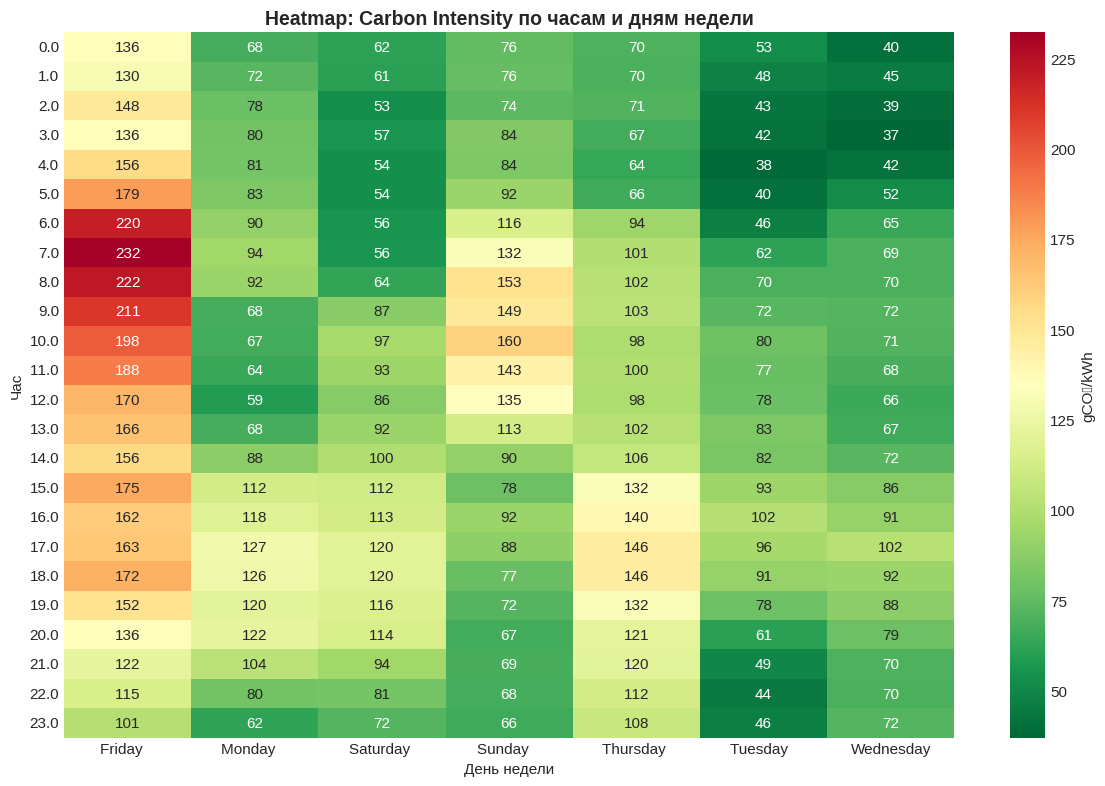


Самые 'грязные' периоды:
           period_start  forecast_co2_gco2_kwh time_of_day
519 2025-12-05 06:30:00                    237     morning
37  2025-12-12 07:30:00                    234     morning
38  2025-12-12 07:30:00                    234     morning
518 2025-12-05 07:00:00                    234     morning
39  2025-12-12 07:00:00                    232     morning


In [21]:
# Heatmap: интенсивность по часам и дням недели
pivot_hour_day = df.pivot_table(
    values='forecast_co2_gco2_kwh',
    index='data_hour',
    columns='data_day_of_week',
    aggfunc='mean'
)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_hour_day, annot=True, fmt='.0f', cmap='RdYlGn_r', 
            cbar_kws={'label': 'gCO₂/kWh'})
plt.title('Heatmap: Carbon Intensity по часам и дням недели', fontsize=14, fontweight='bold')
plt.xlabel('День недели')
plt.ylabel('Час')
plt.tight_layout()
plt.show()

print("\nСамые 'грязные' периоды:")
peak_periods = df.nlargest(5, 'forecast_co2_gco2_kwh')[['period_start', 'forecast_co2_gco2_kwh', 'time_of_day']]
print(peak_periods)

## 5. Анализ точности прогнозов

**Оценка качества прогнозирования carbon intensity**

Записей с фактическими данными: 507


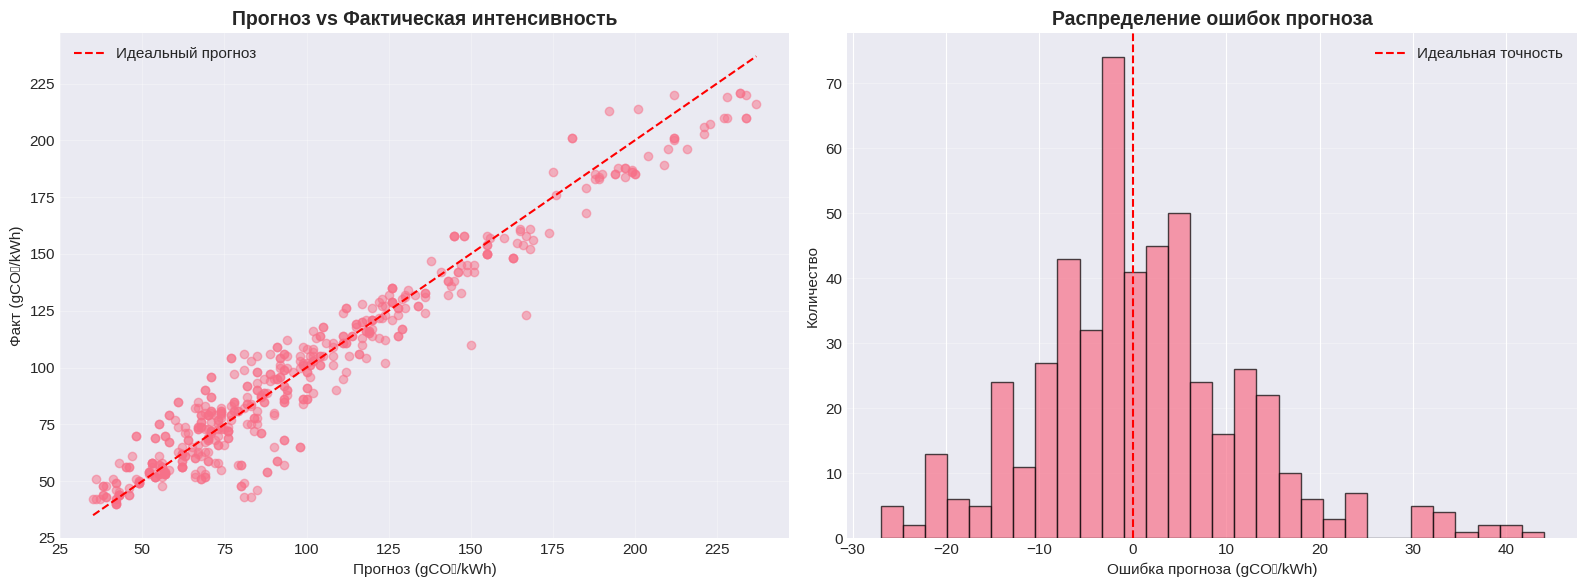


Метрики точности прогнозов:
MAE (средняя абсолютная ошибка): 8.45 gCO₂/kWh
MAPE (средняя процентная ошибка): 10.10%
Процент точных прогнозов (ошибка <= 10%): 68.0%


In [22]:
# Фильтруем данные с фактами для анализа точности
df_with_actuals = df[df['actual_co2_gco2_kwh'].notna()].copy()

print(f"Записей с фактическими данными: {len(df_with_actuals)}")

if len(df_with_actuals) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # График 1: Прогноз vs Факт
    axes[0].scatter(df_with_actuals['forecast_co2_gco2_kwh'], 
                    df_with_actuals['actual_co2_gco2_kwh'], alpha=0.5)
    
    # Линия идеального прогноза
    min_val = min(df_with_actuals['forecast_co2_gco2_kwh'].min(), 
                  df_with_actuals['actual_co2_gco2_kwh'].min())
    max_val = max(df_with_actuals['forecast_co2_gco2_kwh'].max(), 
                  df_with_actuals['actual_co2_gco2_kwh'].max())
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', label='Идеальный прогноз')
    
    axes[0].set_title('Прогноз vs Фактическая интенсивность', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Прогноз (gCO₂/kWh)')
    axes[0].set_ylabel('Факт (gCO₂/kWh)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # График 2: Распределение ошибок
    axes[1].hist(df_with_actuals['forecast_error'], bins=30, alpha=0.7, edgecolor='black')
    axes[1].axvline(x=0, color='red', linestyle='--', label='Идеальная точность')
    axes[1].set_title('Распределение ошибок прогноза', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Ошибка прогноза (gCO₂/kWh)')
    axes[1].set_ylabel('Количество')
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Метрики точности
    mae = df_with_actuals['forecast_error'].abs().mean()
    mape = (df_with_actuals['forecast_error_percent'].abs().mean() 
            if 'forecast_error_percent' in df_with_actuals.columns else None)
    accuracy_rate = (df_with_actuals['is_forecast_accurate'].sum() / len(df_with_actuals)) * 100
    
    print(f"\nМетрики точности прогнозов:")
    print(f"MAE (средняя абсолютная ошибка): {mae:.2f} gCO₂/kWh")
    if mape:
        print(f"MAPE (средняя процентная ошибка): {mape:.2f}%")
    print(f"Процент точных прогнозов (ошибка <= 10%): {accuracy_rate:.1f}%")
else:
    print("Недостаточно данных с фактическими значениями для анализа точности")

## 6. Детекция аномалий

**Выявление необычных периодов carbon intensity**

Обнаружено аномалий: 12 (2.3%)

Распределение аномалий по типу:
intensity_anomaly_type
unusually_high    9
normal            3
Name: count, dtype: int64


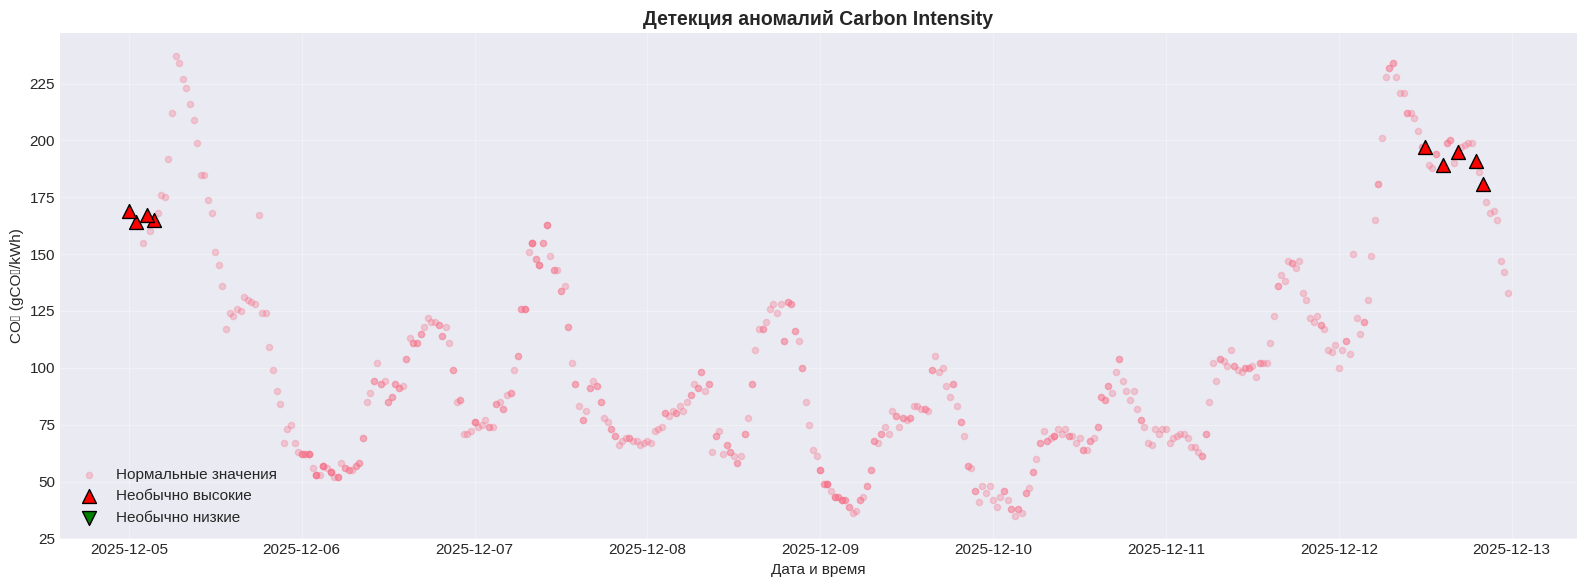


Примеры аномальных периодов:
           period_start  forecast_co2_gco2_kwh intensity_anomaly_type  \
7   2025-12-12 20:00:00                    181         unusually_high   
9   2025-12-12 19:00:00                    191         unusually_high   
14  2025-12-12 16:30:00                    195         unusually_high   
20  2025-12-12 14:30:00                    189         unusually_high   
21  2025-12-12 14:00:00                    188                 normal   
26  2025-12-12 12:00:00                    197         unusually_high   
525 2025-12-05 03:30:00                    165         unusually_high   
527 2025-12-05 02:30:00                    167         unusually_high   
529 2025-12-05 01:30:00                    156                 normal   
530 2025-12-05 01:00:00                    164         unusually_high   

     intensity_z_score  
7             2.039085  
9             2.083460  
14            2.095039  
20            2.214923  
21            2.188783  
26            2.

In [26]:
# Анализ аномалий
anomalies = df[df['is_statistical_anomaly'] == True].copy()

print(f"Обнаружено аномалий: {len(anomalies)} ({len(anomalies)/len(df)*100:.1f}%)")

if len(anomalies) > 0:
    print(f"\nРаспределение аномалий по типу:")
    print(anomalies['intensity_anomaly_type'].value_counts())
    
    # График аномалий
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Нормальные значения
    normal = df[df['is_statistical_anomaly'] == False]
    ax.scatter(normal['period_start'], normal['forecast_co2_gco2_kwh'], 
               alpha=0.3, label='Нормальные значения', s=20)
    
    # Аномалии
    high_anomalies = anomalies[anomalies['intensity_anomaly_type'] == 'unusually_high']
    low_anomalies = anomalies[anomalies['intensity_anomaly_type'] == 'unusually_low']
    
    ax.scatter(high_anomalies['period_start'], high_anomalies['forecast_co2_gco2_kwh'], 
               color='red', label='Необычно высокие', s=100, marker='^', edgecolors='black')
    ax.scatter(low_anomalies['period_start'], low_anomalies['forecast_co2_gco2_kwh'], 
               color='green', label='Необычно низкие', s=100, marker='v', edgecolors='black')
    
    ax.set_title('Детекция аномалий Carbon Intensity', fontsize=14, fontweight='bold')
    ax.set_xlabel('Дата и время')
    ax.set_ylabel('CO₂ (gCO₂/kWh)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nПримеры аномальных периодов:")
    print(anomalies[['period_start', 'forecast_co2_gco2_kwh', 
                     'intensity_anomaly_type', 'intensity_z_score']].head(10))
else:
    print("Аномалий не обнаружено")

## 7. Рекомендации по энергопотреблению

**Практические советы для снижения углеродного следа**

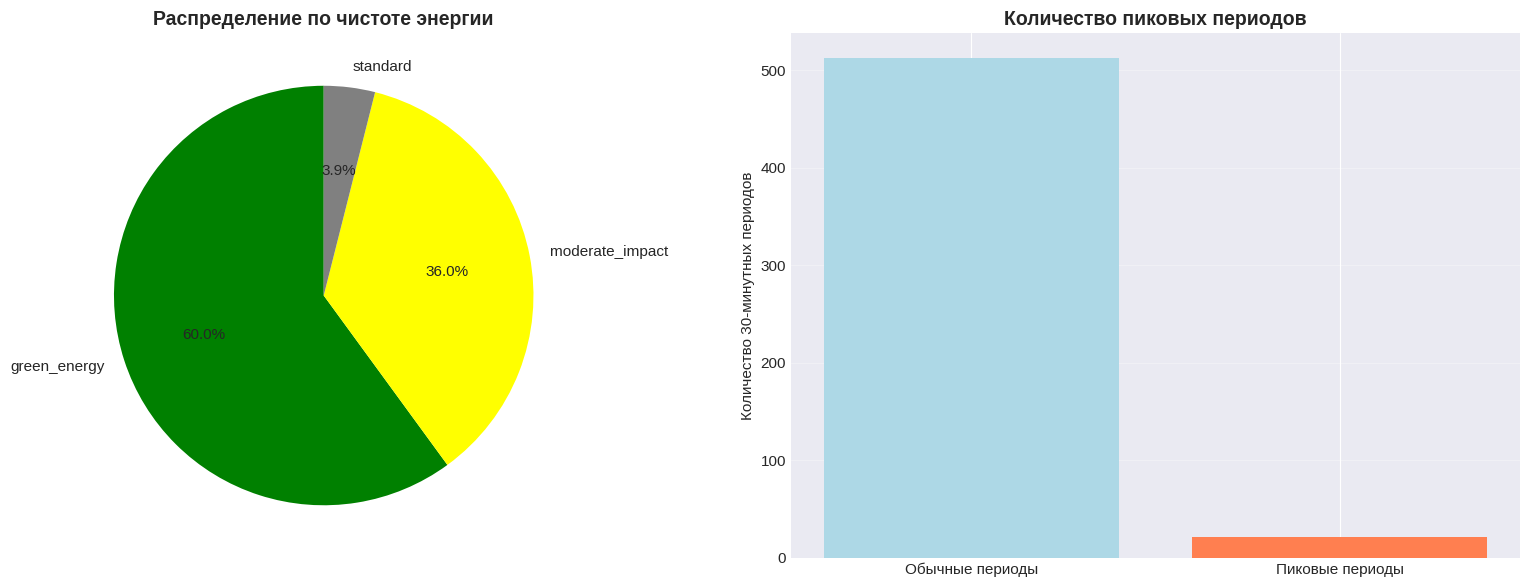


РЕКОМЕНДАЦИИ ПО ЭНЕРГОПОТРЕБЛЕНИЮ:

Лучшие часы для энергопотребления (низкий CO2):
   2.0:00 - 2.0:30 | Интенсивность: 71.6 gCO₂/kWh
   3.0:00 - 3.0:30 | Интенсивность: 73.3 gCO₂/kWh
   1.0:00 - 1.0:30 | Интенсивность: 73.6 gCO₂/kWh

Избегайте этих часов (высокий CO2):
   17.0:00 - 17.0:30 | Интенсивность: 121.8 gCO₂/kWh
   18.0:00 - 18.0:30 | Интенсивность: 122.5 gCO₂/kWh
   9.0:00 - 9.0:30 | Интенсивность: 126.1 gCO₂/kWh

ПОТЕНЦИАЛЬНАЯ ЭКОНОМИЯ CO₂:
   Если перенести 1 кВт⋅ч с обычного времени на оптимальное:
   Экономия: 28.6 gCO2 на каждый кВт⋅ч
   Это 28.6% снижение углеродного следа!

По дням недели:
  weekday: 104.2 gCO2/kWh
  weekend: 91.2 gCO2/kWh


In [27]:
# Распределение по категориям чистоты энергии
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График 1: Круговая диаграмма чистоты энергии
cleanliness_counts = df['energy_cleanliness_level'].value_counts()
colors = {'green_energy': 'green', 'moderate_impact': 'yellow', 
          'high_carbon': 'red', 'standard': 'gray'}
pie_colors = [colors.get(x, 'gray') for x in cleanliness_counts.index]

axes[0].pie(cleanliness_counts.values, labels=cleanliness_counts.index, 
            autopct='%1.1f%%', colors=pie_colors, startangle=90)
axes[0].set_title('Распределение по чистоте энергии', fontsize=14, fontweight='bold')

# График 2: Пиковые периоды
peak_count = df['is_peak_carbon_period'].value_counts()
axes[1].bar(['Обычные периоды', 'Пиковые периоды'], 
            [peak_count.get(False, 0), peak_count.get(True, 0)],
            color=['lightblue', 'coral'])
axes[1].set_title('Количество пиковых периодов', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Количество 30-минутных периодов')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nРЕКОМЕНДАЦИИ ПО ЭНЕРГОПОТРЕБЛЕНИЮ:\n")

# 1. Оптимальные часы
hourly_avg = df.groupby('data_hour')['forecast_co2_gco2_kwh'].mean().sort_values()
best_hours = hourly_avg.head(3)
worst_hours = hourly_avg.tail(3)

print("Лучшие часы для энергопотребления (низкий CO2):")
for hour, intensity in best_hours.items():
    print(f"   {hour}:00 - {hour}:30 | Интенсивность: {intensity:.1f} gCO₂/kWh")

print("\nИзбегайте этих часов (высокий CO2):")
for hour, intensity in worst_hours.items():
    print(f"   {hour}:00 - {hour}:30 | Интенсивность: {intensity:.1f} gCO₂/kWh")

# 2. Потенциальная экономия
avg_intensity = df['forecast_co2_gco2_kwh'].mean()
min_intensity = best_hours.iloc[0]
potential_saving = avg_intensity - min_intensity

print(f"\nПОТЕНЦИАЛЬНАЯ ЭКОНОМИЯ CO₂:")
print(f"   Если перенести 1 кВт⋅ч с обычного времени на оптимальное:")
print(f"   Экономия: {potential_saving:.1f} gCO2 на каждый кВт⋅ч")
print(f"   Это {(potential_saving/avg_intensity)*100:.1f}% снижение углеродного следа!")

# 3. Дни недели
day_avg = df.groupby('day_type')['forecast_co2_gco2_kwh'].mean()
print(f"\nПо дням недели:")
for day_type, intensity in day_avg.items():
    print(f"  {day_type}: {intensity:.1f} gCO2/kWh")

## 8. Выводы и инсайты

**Ключевые находки из анализа данных**

In [28]:
# Сводная таблица инсайтов
insights = {
    'Метрика': [
        'Общее количество записей',
        'Период анализа',
        'Средняя интенсивность CO₂',
        'Минимальная интенсивность',
        'Максимальная интенсивность',
        'Волатильность (std)',
        'Процент пиковых периодов',
        'Процент "зеленой" энергии',
        'Обнаружено аномалий'
    ],
    'Значение': [
        f"{len(df):,}",
        f"{(df['data_date'].max() - df['data_date'].min()).days} дней",
        f"{df['forecast_co2_gco2_kwh'].mean():.2f} gCO₂/kWh",
        f"{df['forecast_co2_gco2_kwh'].min():.2f} gCO₂/kWh",
        f"{df['forecast_co2_gco2_kwh'].max():.2f} gCO₂/kWh",
        f"{df['forecast_co2_gco2_kwh'].std():.2f} gCO₂/kWh",
        f"{(df['is_peak_carbon_period'].sum() / len(df)) * 100:.1f}%",
        f"{(df['energy_cleanliness_level'] == 'green_energy').sum() / len(df) * 100:.1f}%",
        f"{(df['is_statistical_anomaly'] == True).sum()}"
    ]
}

insights_df = pd.DataFrame(insights)
print("\nСВОДНАЯ ТАБЛИЦА ИНСАЙТОВ:\n")
print(insights_df.to_string(index=False))

print("\n\nКЛЮЧЕВЫЕ ВЫВОДЫ:\n")
print("1. Данные собираются регулярно и покрывают последние 30 дней")
print(f"2. Carbon intensity варьируется от {df['forecast_co2_gco2_kwh'].min():.0f} до {df['forecast_co2_gco2_kwh'].max():.0f} gCO₂/kWh")
print(f"3. {(df['energy_cleanliness_level'] == 'green_energy').sum() / len(df) * 100:.1f}% времени - 'зеленая' энергия")
print(f"4. {(df['is_peak_carbon_period'].sum() / len(df)) * 100:.1f}% времени - пиковая углеродная нагрузка")
print(f"5. Оптимизация времени энергопотребления может снизить CO₂ на {(potential_saving/avg_intensity)*100:.1f}%")

if len(df_with_actuals) > 0:
    print(f"6. Точность прогнозов: {accuracy_rate:.1f}% (ошибка <= 10%)")

if len(anomalies) > 0:
    print(f"7. Обнаружено {len(anomalies)} аномальных периодов для дальнейшего анализа")


СВОДНАЯ ТАБЛИЦА ИНСАЙТОВ:

                   Метрика        Значение
  Общее количество записей             533
            Период анализа          7 дней
 Средняя интенсивность CO₂ 100.25 gCO₂/kWh
 Минимальная интенсивность  35.00 gCO₂/kWh
Максимальная интенсивность 237.00 gCO₂/kWh
       Волатильность (std)  46.09 gCO₂/kWh
  Процент пиковых периодов            3.9%
 Процент "зеленой" энергии           60.0%
       Обнаружено аномалий              12


КЛЮЧЕВЫЕ ВЫВОДЫ:

1. Данные собираются регулярно и покрывают последние 30 дней
2. Carbon intensity варьируется от 35 до 237 gCO₂/kWh
3. 60.0% времени - 'зеленая' энергия
4. 3.9% времени - пиковая углеродная нагрузка
5. Оптимизация времени энергопотребления может снизить CO₂ на 28.6%
6. Точность прогнозов: 68.0% (ошибка <= 10%)
7. Обнаружено 12 аномальных периодов для дальнейшего анализа
